In [386]:
import torch
import torchvision

In [387]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [388]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.00001
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [389]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [390]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [391]:
example_data.shape

torch.Size([1000, 1, 28, 28])

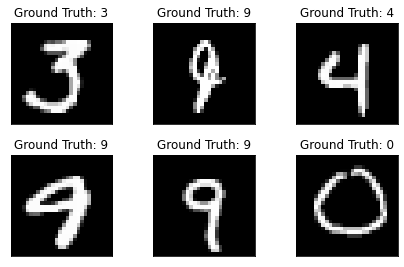

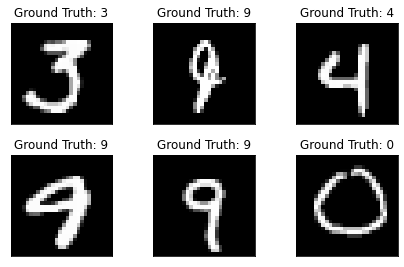

In [392]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
   plt.subplot(2,3,i+1)
   plt.tight_layout()
   plt.imshow(example_data[i][0], cmap = 'gray', interpolation='none')
   plt.title("Ground Truth: {}".format(example_targets[i]))
   plt.xticks([])
   plt.yticks([])
fig

In [393]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [394]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [395]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [396]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [397]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/MyDrive/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/MyDrive/optimizer.pth')

In [398]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [399]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.233555
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.996162
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.538176
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.385254
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.215209
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.016880
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.186422
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.920143
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.053289
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.962119
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.805829
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.867799
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.629441
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.745577
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.560592
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.594725
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.764205
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.619400
Train Epoch: 1 [12160/6

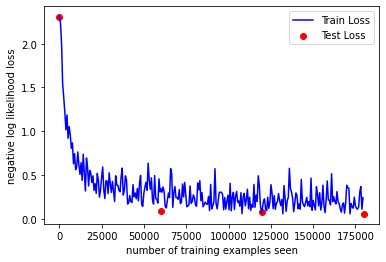

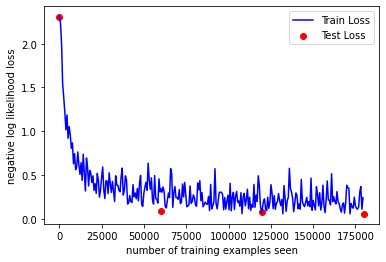

In [400]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [401]:
print(test_counter)
print(test_losses)

[0, 60000, 120000, 180000]
[2.3095823486328126, 0.09372574234008789, 0.07647823677062988, 0.058551631546020506]


In [402]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


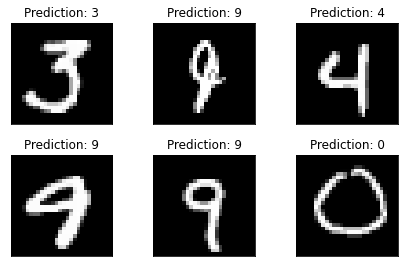

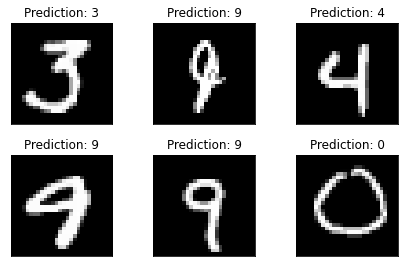

In [403]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [404]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [405]:
network_state_dict = torch.load('/content/drive/MyDrive/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/content/drive/MyDrive/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [406]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.151191
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.188381
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.234827
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.296296
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.241456
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.083146
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.168056
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.522233
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.073283
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.108528
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.181603
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.114075
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.208916
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.361742
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.369921
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.247956
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.083225
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.185887
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.049569
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.201693
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0665, Accuracy: 9790/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.376737
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.299867
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.224717
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.180921
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.224439
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.199471
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.164219
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.178473
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.139892
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.115227
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.182236
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.047991
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.115027
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.123723
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.119183
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.180306
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.172578
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.308483
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.206941
Train Epoch: 5 [12160

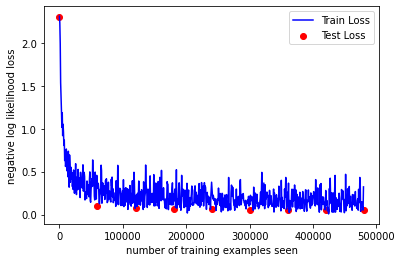

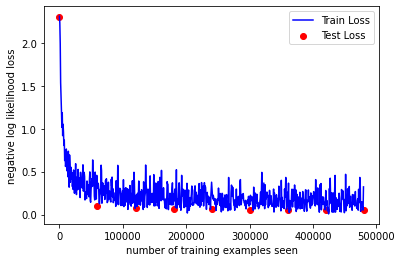

In [407]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [408]:
print(min(test_losses))
print(min(train_losses))


0.047169560623168946
0.0068514468148350716


In [409]:
import matplotlib.pyplot as plt
import numpy as np



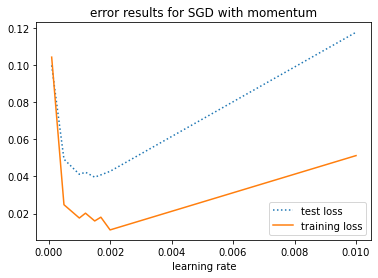

In [435]:
x = np.array([0.0001 ,
    0.0005,
    0.001,
    0.0012,
    0.0015,
    0.0017,
     0.002,
     0.01])
y = np.array([0.0998,
    0.04928,
    0.04115,
     0.04224,
    0.0396,
    0.04082,
     0.04274,
     0.1176])
z = np.array([0.1042,
    0.02476,
    0.0176,
    0.02021,
    0.01602,
     0.01805,
     0.0112,
     0.0512])
plt.plot(x, y, label = "test loss", linestyle=":")
plt.plot(x, z, label = "training loss", linestyle="-")
plt.legend()
plt.xlabel('learning rate')
plt.title("error results for SGD with momentum")
plt.show()

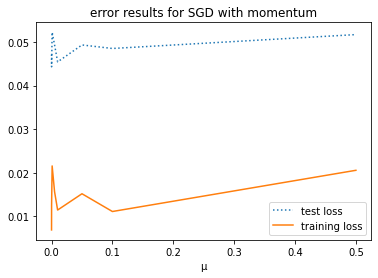

In [434]:
x = np.array([0.00001,
    0.0001,
    0.001,
    0.005,
    0.01,
    0.05,
     0.1,
     0.5])
y = np.array([0.04716,
    0.04433,
    0.05227,
    0.04935,
    0.04546,
    0.04935,
     0.04854,
    0.05173])
z = np.array([0.006851,
    0.01254 ,
     0.02155,
    0.01561,
    0.01142,
     0.01516,
     0.01108,
     0.02055])
plt.plot(x, y, label = "test loss", linestyle=":")
plt.plot(x, z, label = "training loss", linestyle="-")
plt.legend()
plt.xlabel('\u03bc')
plt.title("error results for SGD with momentum")
plt.show()

